In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

train = pd.read_csv('/content/drive/MyDrive/dacon/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon/test.csv')
train_df = train.drop(['ID'],axis=1)
test_df = test.drop(['ID'],axis=1)

In [11]:
test_df.columns

Index(['사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형'], dtype='object')

train, test 데이터 기간 확인하기

In [12]:
display(f"train : {train_df.iloc[0]['사고일시']} ~ {train_df.iloc[-1]['사고일시']}")
display(f"test : {test_df.iloc[0]['사고일시']} ~ {test_df.iloc[-1]['사고일시']}")

'train : 2019-01-01 00 ~ 2021-12-31 23'

'test : 2022-01-01 01 ~ 2022-12-31 21'

## **데이터 전처리**  

현재 '사고일시', '시군구', '도로형태' 컬럼은 반복되는 패턴으로 여러 정보를 포함하고 있습니다
이런 반복되는 패턴을 일반화하면 pandas에서 제공하는 str.extract를 통해 한 번에 추출 가능합니다  

**파생 변수 생성 1 : 날짜, 시간정보 생성**

'사고일시' 컬럼으로 부터 연도, 월, 일, 시간 정보 추출 및 변환 합니다

In [13]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',\n       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

**파생 변수 생성 2 : 공간(위치) 정보 생성**

'시군구' 컬럼으로부터 의미 있는 공산 정보를 추출 및 변환 합니다

In [14]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',\n       '월', '일', '시간', '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구',\n       '동'],\n      dtype='object')"

In [15]:
OD = pd.read_csv('/content/drive/MyDrive/dacon/2019_OD.csv', encoding = 'utf-8')
OD.drop(columns = ['Unnamed: 5', '년'], inplace = True)

In [16]:
동구_발생량 = OD[OD['구']=='동구']['발생량'].mean()
동구_도착량 = OD[OD['구']=='동구']['도착량'].mean()
중구_발생량 = OD[OD['구']=='중구']['발생량'].mean()
중구_도착량 = OD[OD['구']=='중구']['도착량'].mean()

In [17]:
train_df = pd.merge(left=train_df, right=OD, how='left', on=['구','동'], sort=False)
train_df.loc[(train_df['구'] == '동구') & (train_df['발생량'].isnull()), '발생량'] = 동구_발생량
train_df.loc[(train_df['구'] == '동구') & (train_df['도착량'].isnull()), '도착량'] = 동구_도착량
train_df.loc[(train_df['구'] == '중구') & (train_df['발생량'].isnull()), '발생량'] = 중구_발생량
train_df.loc[(train_df['구'] == '중구') & (train_df['도착량'].isnull()), '도착량'] = 중구_도착량

In [18]:
test_df = pd.merge(left=test_df, right=OD, how='left', on=['구','동'], sort=False)
test_df.loc[(test_df['구'] == '동구') & (test_df['발생량'].isnull()), '발생량'] = 동구_발생량
test_df.loc[(test_df['구'] == '동구') & (test_df['도착량'].isnull()), '도착량'] = 동구_도착량
test_df.loc[(test_df['구'] == '중구') & (test_df['발생량'].isnull()), '발생량'] = 중구_발생량
test_df.loc[(test_df['구'] == '중구') & (test_df['도착량'].isnull()), '도착량'] = 중구_도착량

**파생 변수 추출 3 : 도로 형태 정보 추출**  

'도로형태' 컬럼은 '단일로 - 기타'와 같은 패턴으로 구성되어 있습니다. 이를 두종류의 독립된 정보로 보고 두개의 컬럼으로 분리하여 생성합니다.

In [19]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',\n       '월', '일', '시간', '도시', '구', '동', '발생량', '도착량', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '발생량', '도착량', '도로형태1', '도로형태2'],\n      dtype='object')"

In [20]:
train_df.drop('도시',axis=1,inplace=True)
test_df.drop('도시',axis=1,inplace=True)

### 추가 데이터 

- 대구 보안등 정보
- 대구 어린이 보호 구역 정보
- 대구 주차장 정보
- 대구 CCTV 정보
- countrywide_accident

---- 
1. 대구 보안등 정보

In [21]:
light = pd.read_csv('/content/drive/MyDrive/dacon/light.csv')
light.head()

<ipython-input-21-5207e14a0a3d>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  light = pd.read_csv('/content/drive/MyDrive/dacon/light.csv')


,보안등위치명,설치개수,소재지도로명주소,소재지지번주소,위도,경도,설치연도,설치형태
0,대명1동1,1,대구광역시 남구 현충로 155,대구광역시 남구 대명동 1722-4,35.846703,128.579803,2016.0,한전주
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,대구광역시 남구 대명동 1723-11,35.846863,128.579406,2016.0,한전주
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,대구광역시 남구 대명동 1722-56,35.846341,128.579342,2017.0,건축물
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,대구광역시 남구 대명동 1722-41,35.846368,128.578922,2016.0,한전주
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,대구광역시 남구 대명동 1721-22,35.845995,128.578858,2016.0,한전주


In [24]:
def black_split_1(x):
    return x.split(' ')[1]

def black_split_2(x):
    try:
        return x.split(' ')[2]
    except:
        return x

light['구'] = light['소재지지번주소'].apply(black_split_1)
light['동'] = light['소재지지번주소'].apply(black_split_2)
light.head()

,보안등위치명,설치개수,소재지도로명주소,소재지지번주소,위도,경도,설치연도,설치형태,구,동
0,대명1동1,1,대구광역시 남구 현충로 155,대구광역시 남구 대명동 1722-4,35.846703,128.579803,2016.0,한전주,남구,대명동
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,대구광역시 남구 대명동 1723-11,35.846863,128.579406,2016.0,한전주,남구,대명동
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,대구광역시 남구 대명동 1722-56,35.846341,128.579342,2017.0,건축물,남구,대명동
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,대구광역시 남구 대명동 1722-41,35.846368,128.578922,2016.0,한전주,남구,대명동
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,대구광역시 남구 대명동 1721-22,35.845995,128.578858,2016.0,한전주,남구,대명동


In [25]:
pattern = r'(\w+동)'
light['동'] = light['동'].str.extract(pattern)

In [26]:
dong_install = light.groupby(['동'])[['설치개수']].mean()
#dong_install

----
2. 대구 어린이 보호 구역 정보

In [27]:
chil_info = pd.read_csv('/content/drive/MyDrive/dacon/대구 어린이 보호 구역 정보.csv',encoding='cp949')
#chil_info.head()

In [28]:
def black_split_1(x):
    try:
        return x.split(' ')[1]
    except:
        return x
    
def black_split_2(x):
    try:
        return x.split(' ')[2]
    except:
        return x

In [30]:
chil_info['구'] = chil_info['소재지지번주소'].apply(black_split_1)
chil_info['동'] = chil_info['소재지지번주소'].apply(black_split_2)

In [32]:
pattern = r'(\w+동)'
chil_info['동'] = chil_info['동'].str.extract(pattern)
cctv_count = chil_info[chil_info['CCTV설치대수'].notnull()].groupby(['동'])[['CCTV설치대수']].mean()

-----
3. 대구 주차장 정보

In [33]:
park = pd.read_csv('/content/drive/MyDrive/dacon/대구 주차장 정보.csv',encoding='cp949')

In [34]:
park.columns

Index(['주차장관리번호', '주차장명', '주차장구분', '주차장유형', '소재지도로명주소', '소재지지번주소', '주차구획수',
       '급지구분', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항',
       '위도', '경도', '데이터기준일자'],
      dtype='object')

----
4. 대구 cctv 정보

In [35]:
cctv = pd.read_csv('/content/drive/MyDrive/dacon/대구 CCTV 정보.csv',encoding='cp949')
#cctv.head()

In [36]:
cctv['구'] = cctv['소재지지번주소'].apply(black_split_1)
cctv['동'] = cctv['소재지지번주소'].apply(black_split_2)
#cctv.head()

In [37]:
speed_cctv = cctv[cctv['제한속도'] > 0].groupby(['동'])[['제한속도']].mean()
#speed_cctv

----- 
### 데이터 합치기

- dong_install
- cctv_count
- speed_cctv

In [41]:
train_df.columns

Index(['요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', '구', '동', '발생량', '도착량', '도로형태1', '도로형태2'],
      dtype='object')

In [39]:
dong_install = dong_install.reset_index()
cctv_count = cctv_count.reset_index()
speed_cctv  = speed_cctv.reset_index()

In [ ]:
train_df.shape

(39609, 29)

In [ ]:
tr_df = pd.merge(train_df,dong_install,how='left',on='동')
tr_df = pd.merge(tr_df,cctv_count,how='left',on='동')
tr_df = pd.merge(tr_df,speed_cctv,how='left',on='동')
#tr_df

In [45]:
test_df.shape

(10963, 14)

In [ ]:
te_df = pd.merge(test_df,dong_install,how='left',on='동')
te_df = pd.merge(te_df ,cctv_count,how='left',on='동')
te_df = pd.merge(te_df ,speed_cctv,how='left',on='동')
#te_df

---- 
### null 값 처리하기

#### Columns
##### Time feature
    - 사고일시 : year / month(season / quarter / half) / day(월초 / 월말) / hour(morning) / weekday(주말여부)
    
##### Numeric feature
    - 가해운전자 연령 / 피해운전자 연령 / 사망자수 / 중상자수 / 경상자수 / 부상자수
    
##### Categorical feature - high cardinality

train

In [47]:
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   요일           39609 non-null  object 
 1   기상상태         39609 non-null  object 
 2   노면상태         39609 non-null  object 
 3   사고유형         39609 non-null  object 
 4   사고유형 - 세부분류  39609 non-null  object 
 5   법규위반         39609 non-null  object 
 6   가해운전자 차종     39609 non-null  object 
 7   가해운전자 성별     39609 non-null  object 
 8   가해운전자 연령     39609 non-null  object 
 9   가해운전자 상해정도   39609 non-null  object 
 10  피해운전자 차종     38618 non-null  object 
 11  피해운전자 성별     38618 non-null  object 
 12  피해운전자 연령     38618 non-null  object 
 13  피해운전자 상해정도   38618 non-null  object 
 14  사망자수         39609 non-null  int64  
 15  중상자수         39609 non-null  int64  
 16  경상자수         39609 non-null  int64  
 17  부상자수         39609 non-null  int64  
 18  ECLO         39609 non-null  int64  
 19  연   

In [49]:
tr_df.rename(columns={'설치개수':'보안등 설치개수'},inplace=True)

In [51]:
corr = tr_df[['CCTV설치대수','보안등 설치개수','제한속도']].corr(numeric_only=True)
corr

,CCTV설치대수,보안등 설치개수,제한속도
CCTV설치대수,1.000000,0.088514,0.390686
보안등 설치개수,0.088514,1.000000,0.092635
제한속도,0.390686,0.092635,1.000000


In [ ]:
tr_df[['CCTV설치대수','보안등 설치개수','제한속도']].describe()

,CCTV설치대수,보안등 설치개수,제한속도
count,8772.000000,25869.000000,37167.000000
mean,3.899129,1.008551,47.298446
std,1.344327,0.015354,7.436987
min,1.000000,1.000000,30.000000
25%,3.285714,1.000000,42.666667
50%,3.846154,1.000000,47.037037
75%,4.250000,1.017341,50.000000
max,12.000000,1.166667,100.000000


In [52]:
tr_df['CCTV설치대수'] = tr_df['CCTV설치대수'].interpolate()
tr_df['보안등 설치개수'] = tr_df['보안등 설치개수'].interpolate()
tr_df['제한속도'] = tr_df['제한속도'].interpolate()

In [54]:
tr_df[tr_df['피해운전자 상해정도'].isnull() & tr_df['피해운전자 연령'].isnull()  & tr_df['피해운전자 성별'].isnull()  & tr_df['피해운전자 차종'].isnull()]['사고유형'].value_counts()

차량단독    991
Name: 사고유형, dtype: int64

In [55]:
tr_df['피해운전자 상해정도'].fillna(tr_df['가해운전자 상해정도'],inplace=True)
tr_df['피해운전자 연령'].fillna(tr_df['가해운전자 연령'],inplace=True)
tr_df['피해운전자 성별'].fillna(tr_df['가해운전자 성별'],inplace=True)
tr_df['피해운전자 차종'].fillna(tr_df['가해운전자 차종'],inplace=True)

---- 
### 시각화

In [58]:
tr_df.columns

Index(['요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', '구', '동', '발생량', '도착량', '도로형태1', '도로형태2', '보안등 설치개수',
       'CCTV설치대수', '제한속도'],
      dtype='object')

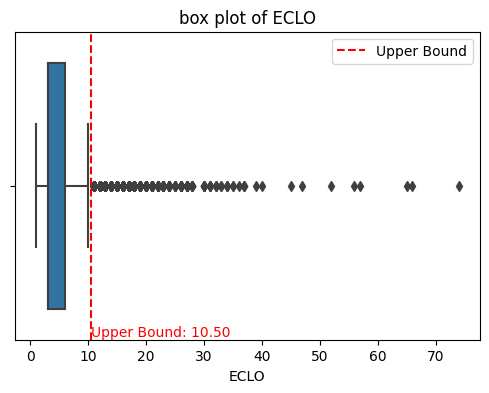

In [ ]:
Q1 = tr_df['ECLO'].quantile(0.25)
Q3 = tr_df['ECLO'].quantile(0.75)
IQR = Q3-Q1

upper_bound = Q3 + 1.5 * IQR



plt.figure(figsize=(6,4))
sns.boxplot(x='ECLO', data=tr_df)

plt.axvline(x=upper_bound, color='r', linestyle='--', label='Upper Bound')

plt.text(upper_bound+12, 0.5, f'Upper Bound: {upper_bound:.2f}', color='r', ha='center', va='bottom')

plt.legend()

plt.title("box plot of ECLO")
plt.show()

In [ ]:
high_ECLO_df = tr_df[tr_df['ECLO'] > 10.5]
no_high_ECLO_df = tr_df[tr_df['ECLO'] <= 10.5]

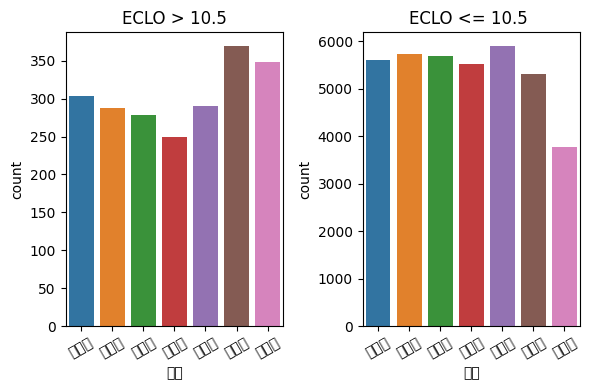

In [ ]:
# ECLO 10.5 이상은 주말 발생 비율이 높다, 10.5 이하는 주말 사고 발생 비율이 더 낮다.

x_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

fig, axes = plt.subplots(1, 2, figsize=(6,4))
sns.countplot(x='요일', data=high_ECLO_df, order=x_order, ax=axes[0])
sns.countplot(x='요일', data=no_high_ECLO_df, order=x_order, ax=axes[1])
axes[0].tick_params(axis='x', rotation=30)
axes[1].tick_params(axis='x', rotation=30)

axes[0].set_title("ECLO > 10.5")
axes[1].set_title("ECLO <= 10.5 ")

plt.tight_layout()
plt.show()

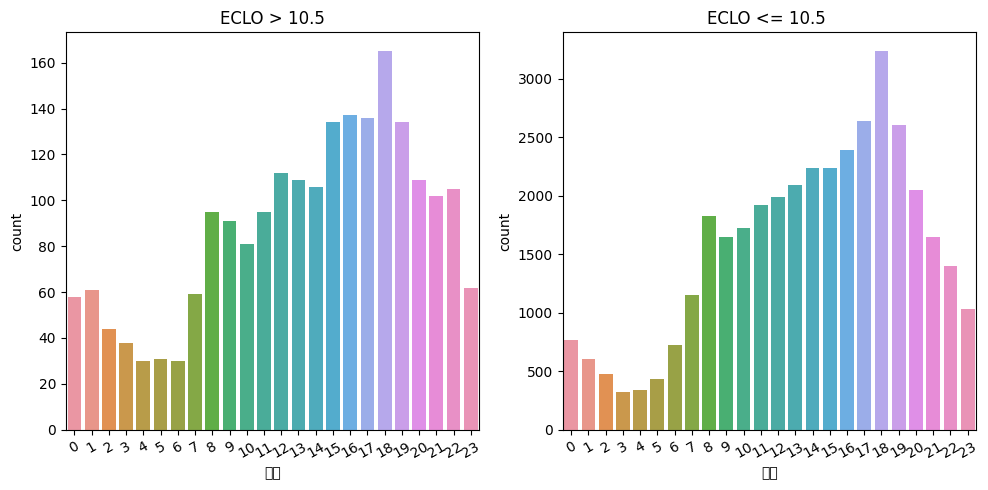

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.countplot(x='시간', data=high_ECLO_df,  ax=axes[0])
sns.countplot(x='시간', data=no_high_ECLO_df,  ax=axes[1])
axes[0].tick_params(axis='x', rotation=30)
axes[1].tick_params(axis='x', rotation=30)

axes[0].set_title("ECLO > 10.5")
axes[1].set_title("ECLO <= 10.5 ")

plt.tight_layout()
plt.show()

In [ ]:
tr_df.groupby(['도로형태1','도로형태2'])[['ECLO']].mean()

ECLO
도로형태1 도로형태2              
교차로   교차로부근      4.863035
      교차로안       5.006142
      교차로횡단보도내   4.122795
기타    기타         4.065962
단일로   고가도로위      5.615942
      교량         5.211207
      기타         4.653990
      지하차도(도로)내  4.576052
      터널         6.578125
미분류   미분류        3.750000
주차장   주차장        3.716102

In [59]:
# 도로형태2가 도로형태1의 내용을 포함하고 있음으로 제거함
tr_df.drop(['도로형태1'],axis=1,inplace=True)
tr_df.rename(columns={'도로형태2':'도로형태'},inplace=True)
tr_df.columns

Index(['요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', '구', '동', '발생량', '도착량', '도로형태', '보안등 설치개수', 'CCTV설치대수',
       '제한속도'],
      dtype='object')

In [60]:
col_name = {'요일':'week','기상상태':'weather','노면상태':'surface','사고유형':'how_accident','사고유형 - 세부분류':'accident_detail','법규위반':'nolaw',
                        '가해운전자 차종':'perpetrator_car','가해운전자 성별':'perpetrator_sex','가해운전자 연령':'perpetrator_age','가해운전자 상해정도':'perpetrator_injury','피해운전자 차종':'victim_car',
                        '피해운전자 성별':'victim_sex','피해운전자 연령':'victim_age','피해운전자 상해정도':'victim_injury','사망자수':'dead','중상자수':'seriously_injured','경상자수':'minor_casualty','부상자수':'injured',
                        '연':'year','월':'month','일':'day','시간':'hour','구':'gu','동':'dong','도로형태':'road','보안등 설치개수':'light','CCTV설치대수':'CCTV','제한속도':'limitspeed'}

In [61]:
tr_df.rename(columns=col_name,inplace=True)
tr_df.columns

Index(['week', 'weather', 'surface', 'how_accident', 'accident_detail',
       'nolaw', 'perpetrator_car', 'perpetrator_sex', 'perpetrator_age',
       'perpetrator_injury', 'victim_car', 'victim_sex', 'victim_age',
       'victim_injury', 'dead', 'seriously_injured', 'minor_casualty',
       'injured', 'ECLO', 'year', 'month', 'day', 'hour', 'gu', 'dong', '발생량',
       '도착량', 'road', 'light', 'CCTV', 'limitspeed'],
      dtype='object')

test

In [62]:
te_df.isnull().sum()

요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
구              0
동              0
발생량            0
도착량            0
도로형태1          0
도로형태2          0
설치개수        3999
CCTV설치대수    8550
제한속도         729
dtype: int64

In [63]:
te_df.rename(columns={'설치개수':'보안등 설치개수'},inplace=True)

In [64]:
te_df['CCTV설치대수'] = te_df['CCTV설치대수'].fillna(te_df['CCTV설치대수'].mean())
te_df['보안등 설치개수'] = te_df['보안등 설치개수'].interpolate()
te_df['제한속도'] = te_df['제한속도'].interpolate()

In [65]:
te_df.isnull().sum()

요일          0
기상상태        0
노면상태        0
사고유형        0
연           0
월           0
일           0
시간          0
구           0
동           0
발생량         0
도착량         0
도로형태1       0
도로형태2       0
보안등 설치개수    0
CCTV설치대수    0
제한속도        0
dtype: int64

In [66]:
# 도로형태2가 도로형태1의 내용을 포함하고 있음으로 제거함
te_df.drop(['도로형태1'],axis=1,inplace=True)
te_df.rename(columns={'도로형태2':'도로형태'},inplace=True)
te_df.columns

Index(['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '발생량',
       '도착량', '도로형태', '보안등 설치개수', 'CCTV설치대수', '제한속도'],
      dtype='object')

In [67]:
col_name = {'요일':'week','기상상태':'weather','노면상태':'surface','사고유형':'how_accident',
                     '연':'year','월':'month','일':'day','시간':'hour','구':'gu','동':'dong','도로형태':'road','보안등 설치개수':'light','CCTV설치대수':'CCTV','제한속도':'limitspeed'}

In [68]:
te_df.rename(columns=col_name,inplace=True)
te_df.columns

Index(['week', 'weather', 'surface', 'how_accident', 'year', 'month', 'day',
       'hour', 'gu', 'dong', '발생량', '도착량', 'road', 'light', 'CCTV',
       'limitspeed'],
      dtype='object')

### 인코딩

In [71]:
te_df.columns
#카테고리 열이 아니면 그래프 그려서 분포 확인해보기

Index(['week', 'weather', 'surface', 'how_accident', 'year', 'month', 'day',
       'hour', 'gu', 'dong', '발생량', '도착량', 'road', 'light', 'CCTV',
       'limitspeed'],
      dtype='object')

In [72]:
train_x = tr_df[te_df.columns].copy()
train_y = tr_df['ECLO'].copy()

In [73]:
categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
categorical_features

['week', 'weather', 'surface', 'how_accident', 'gu', 'dong', 'road']

In [74]:
categorical_features_test = list(te_df.dtypes[te_df.dtypes == "object"].index)
categorical_features_test

['week', 'weather', 'surface', 'how_accident', 'gu', 'dong', 'road']

In [75]:
numeric_features_test = list(te_df.dtypes[te_df.dtypes == "int"].index)
numeric_features_test.extend(list(te_df.dtypes[te_df.dtypes == "float"].index))

In [76]:
numeric_features_test

['year', 'month', 'day', 'hour', '발생량', '도착량', 'light', 'CCTV', 'limitspeed']

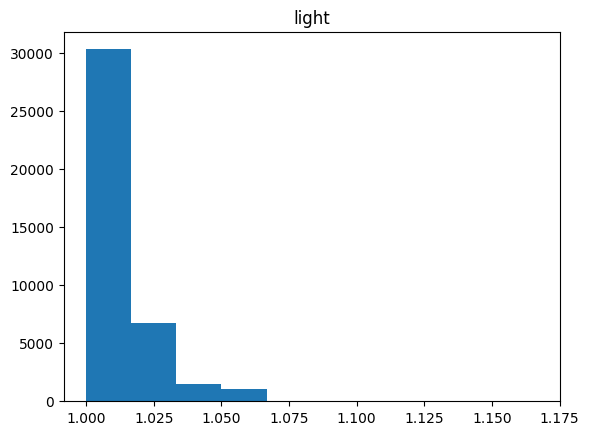

In [ ]:
plt.hist(train_x['light'])
plt.title('light')
plt.show()

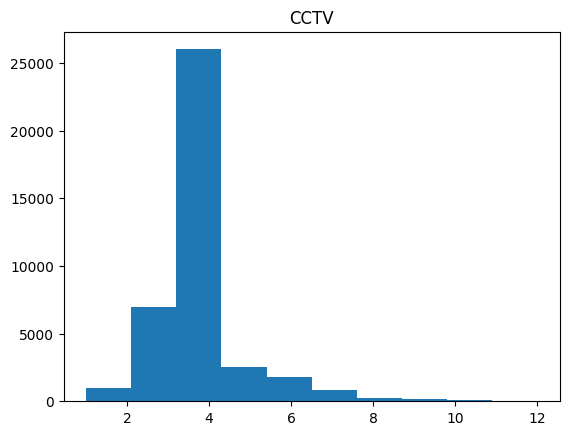

In [ ]:
plt.hist(train_x['CCTV'])
plt.title('CCTV')
plt.show()

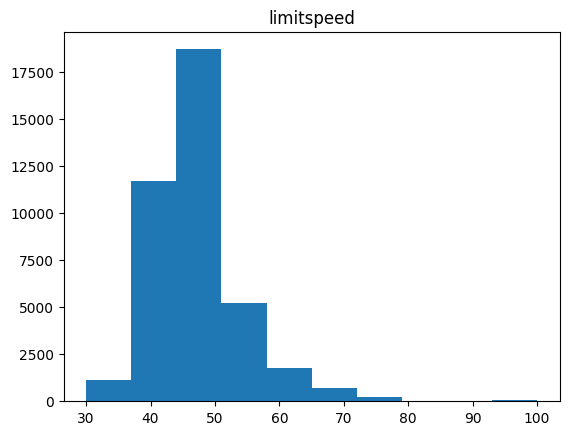

In [ ]:
plt.hist(train_x['limitspeed'])
plt.title('limitspeed')
plt.show()

In [77]:
train_x[train_x['limitspeed'] == train_x['limitspeed'].max()].head()

,week,weather,surface,how_accident,year,month,day,hour,gu,dong,발생량,도착량,road,light,CCTV,limitspeed
317,금요일,맑음,건조,차대차,2019,1,11,8,동구,율암동,1.249000e+03,231.000000,기타,1.010870,2.837607,100.0
1823,월요일,맑음,건조,차대차,2019,2,25,9,동구,도동,1.111666e+06,607255.461538,기타,1.009709,3.923077,100.0
2119,월요일,맑음,건조,차대차,2019,3,4,20,동구,율암동,1.249000e+03,231.000000,교차로부근,1.010870,3.374205,100.0
2685,화요일,맑음,건조,차대차,2019,3,19,12,동구,도동,1.111666e+06,607255.461538,기타,1.009709,3.846154,100.0
4089,월요일,기타,건조,차대사람,2019,4,22,18,동구,율암동,1.249000e+03,231.000000,기타,1.010870,3.551186,100.0


In [ ]:
train_x['light'].describe()

count    39609.000000
mean         1.008551
std          0.014053
min          1.000000
25%          1.000000
50%          1.000000
75%          1.015737
max          1.166667
Name: light, dtype: float64

In [ ]:
te_df['light'].describe()

count    10963.000000
mean         1.008669
std          0.014224
min          1.000000
25%          1.000000
50%          1.000000
75%          1.015737
max          1.166667
Name: light, dtype: float64

In [78]:
def change_range(x):
  if x > train_x['light'].mean():
    return 1
  else:
    return 0
train_x['light_range'] = train_x['light'].apply(change_range)

In [80]:
train_x['light_range'].value_counts()

0    26526
1    13083
Name: light_range, dtype: int64

In [82]:
def change_range_test(x):
  if x > te_df['light'].mean():
    return 1
  else:
    return 0
te_df['light_range'] = te_df['light'].apply(change_range_test)
te_df['light_range'].value_counts()

0    7293
1    3670
Name: light_range, dtype: int64

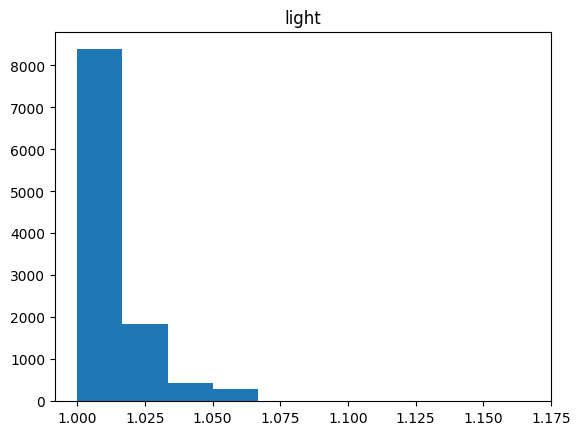

In [ ]:
plt.hist(te_df['light'])
plt.title('light')
plt.show()

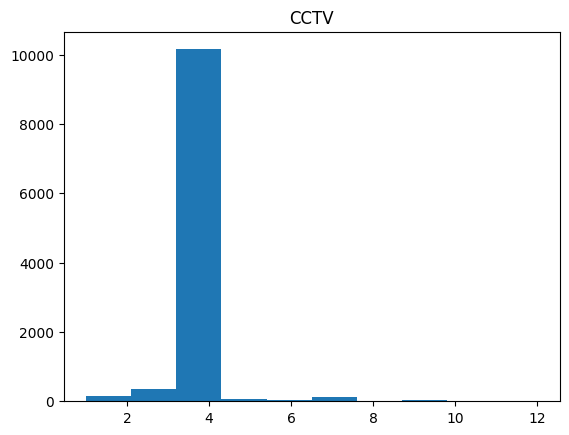

In [ ]:
plt.hist(te_df['CCTV'])
plt.title('CCTV')
plt.show()

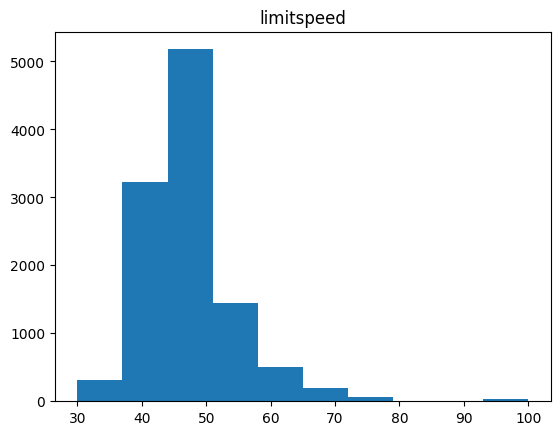

In [ ]:
plt.hist(te_df['limitspeed'])
plt.title('limitspeed')
plt.show()